# **Plots and Tables**

In [1]:
from axisvm.com.client import start_AxisVM
axvm = start_AxisVM(visible=True, daemon=True)

In [2]:
import axisvm.com.tlb as axtlb
from axisvm import examples

## AxisVM

In [3]:
axvm.model = examples.download_bernoulli_grid()

In [4]:
axm = axvm.model
axm.Calculation.LinearAnalysis()

# turn off the grid
GridOptions = axtlb.RGridOptions(DisplayGrid=False)
axm.Settings.SetGridOptions(GridOptions)

 1]

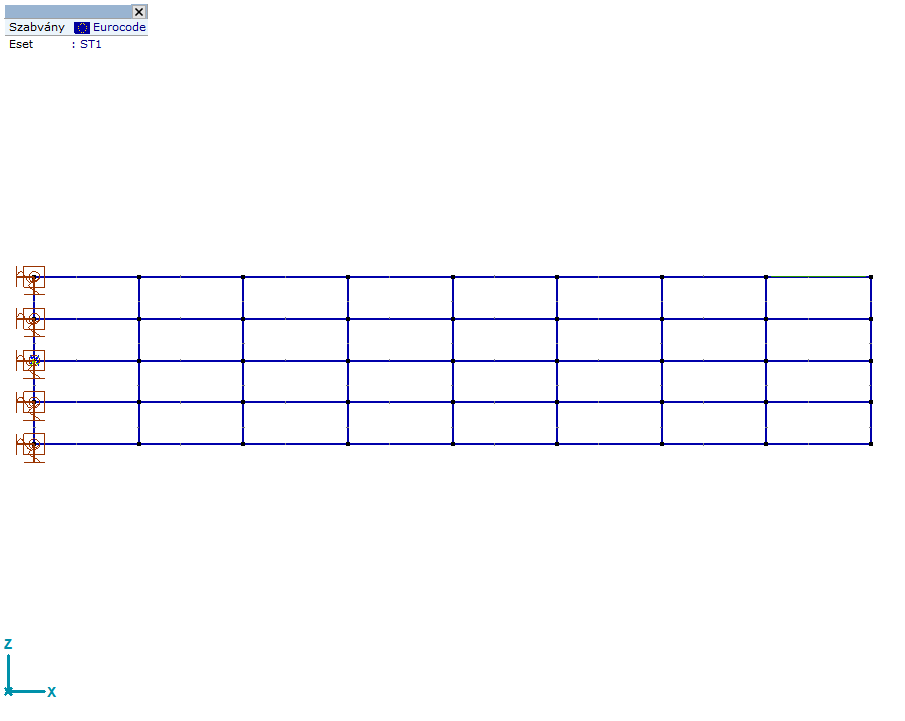

In [5]:
axvm.BringToFront()
axm.View = axtlb.vFront
axvm.MainFormTab = axtlb.mftGeometry
axm.FitInView()
axm.Windows[1].screenshot()

In [6]:
axm.Lines.get_line_data(fields=['NodeId1', 'NodeId2', 'GeomType']).to_pandas()

,NodeId1,NodeId2,GeomType
0,1,2,StraightLine
1,1,6,StraightLine
2,1,26,StraightLine
3,2,3,StraightLine
4,2,7,StraightLine
...,...,...,...
759,309,337,StraightLine
760,257,338,StraightLine
761,276,338,StraightLine
762,298,338,StraightLine


In [7]:
import plotly.graph_objects as go
fields = ['NodeId1', 'NodeId2', 'GeomType']
d = axm.Lines.get_line_data(fields=fields)
tbl = go.Table(header=dict(values=list(d.keys())),
               cells=dict(values=list(d.values())))
fig = go.Figure(data=[tbl])
fig.update_layout(width=800, height=400)
fig.show()

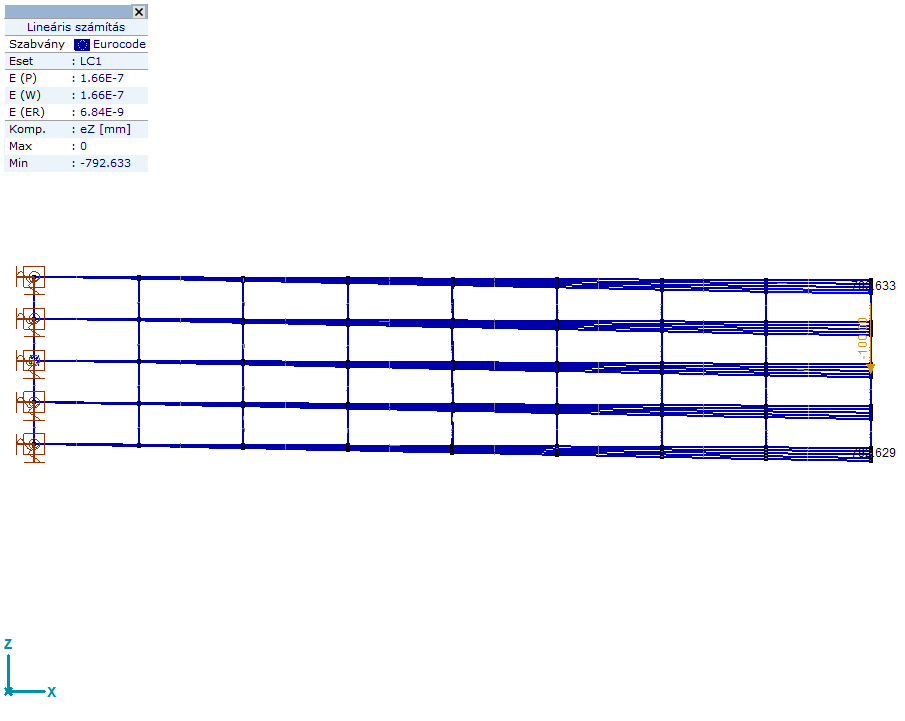

In [8]:
axvm.MainFormTab = axtlb.mftStatic

WriteValuesTo = axtlb.RWriteValuesTo(
    Nodes=True,
    Lines=False,
    Surfaces=False,
    MinMaxOnly=True
)
BasicDispParams = axtlb.RBasicDisplayParameters_V153(
    ResultComponent=axtlb.rc_d_eZ,
    Scale=1.0,
    DisplayMode=axtlb.dmDiagram,
    DisplayShape=axtlb.dsDeformed,
    WriteValuesTo=WriteValuesTo
)
ExtDispParams = axtlb.RExtendedDisplayParameters_V153(
    BasicDispParams=BasicDispParams,
    DisplayAnalysisType=axtlb.datLinear,
    ResultType=axtlb.rtLoadCombination
)
axm.Windows.SetStaticDisplayParameters_V153(1, ExtDispParams, 2, [])

axm.Windows.ReDraw()
axm.Windows[1].screenshot()

## Plotly

In [10]:
from dewloosh.plotly import plot_lines_3d
coords = axm.coordinates()
topo = axm.Members.topology() - 1
plot_lines_3d(coords, topo)


### Plotly with JupyterDash

This requires ``jupyter-dash`` to be installed!

In [ ]:
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import dcc, html
from dash.dependencies import Input, Output

# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("Plotly | JupyterDash"),
    dcc.Graph(id='graph'),
    html.Label([
        "colorscale",
        dcc.Dropdown(
            id='colorscale-dropdown', clearable=False,
            value='plasma', options=[
                {'label': c, 'value': c}
                for c in px.colors.named_colorscales()
            ])
    ]),
])

# Define callback to update graph
@app.callback(
    Output('graph', 'figure'),
    [Input("colorscale-dropdown", "value")]
)
def update_figure(colorscale):
    return plot_lines_3d(coords, topo)


# Run app and display result inline in the notebook
app.run_server(mode='inline')


### Plotly with JupyterDash and VTK

In [ ]:
from sigmaepsilon import Structure, LineMesh, PointData, FemMesh
from sigmaepsilon.math.linalg import linspace, Vector
from sigmaepsilon.mesh.space import StandardFrame, PointCloud, frames_of_lines
from sigmaepsilon.fem.cells import B2 as Beam, Q4M
from dewloosh.mesh.cells import Q4
from dewloosh.math.array import repeat

import numpy as np
from numpy import pi as PI

coords = axm.coords()
topo = axm.topology()
widths = topo.widths()
iL2 = np.where(widths==2)[0]
iT6 = np.where(widths==6)[0]
iQ8 = np.where(widths==8)[0]

GlobalFrame = StandardFrame(dim=3)

# pointdata
pd = PointData(coords=coords, frame=GlobalFrame)
mesh = FemMesh(pd, frame=GlobalFrame)

# celldata
if len(iL2) > 0:
    topoL2 = topo[iL2].to_numpy() - 1
    frames = frames_of_lines(coords, topoL2)
    mesh['lines'] = LineMesh(Beam(topo=topoL2, frames=frames))
if len(iQ8) > 0:
    topoQ4 = topo[iQ8].to_numpy()[:, :4] - 1
    frames = repeat(GlobalFrame.show(), len(topoQ4))
    mesh['surfaces'] = FemMesh(Q4M(topo=topoQ4, frames=frames))


This requires ``dash-vtk`` to be installed!

In [ ]:
from jupyter_dash import JupyterDash
from dash import html

import dash_vtk
from dash_vtk.utils import to_mesh_state

# Use VTK to get some data
datasets = mesh.to_vtk(fuse=False)
#mesh_state = to_mesh_state(ugrid)
vtk_content = dash_vtk.View([
    dash_vtk.GeometryRepresentation(
        children=[
            dash_vtk.Mesh(state=to_mesh_state(datasets[0])),
            dash_vtk.Mesh(state=to_mesh_state(datasets[1]))
            ],
        property={
            "lineWidth ": 10,
            "representation": 1,
            "edgeColor": (0, 0, 0),
            "color" : (1, 1, 1),
            "edgeVisibility " : True
        },
    ),
],
    background=[1, 1, 1])

# Build App
app = JupyterDash(__name__)
app.layout = html.Div(
    style={"width": "100%", "height": "400px"},
    children=[
        html.H1("Plotly | JupyterDash | VTK"),
        vtk_content
    ],
)

# Run app and display result inline in the notebook
app.run_server(mode='inline')
